# Task 4 Time Series Analysis
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to extract the time series


In [82]:
import numpy as np
import math
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax, TimeSeriesResampler
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import accuracy_score, classification_report


In [83]:
dict_colors_bot = { 1: 'teal', 0: 'sandybrown'}

In [84]:
df = pd.read_csv("../dataset/cleaned_joined_tweets.csv", index_col = 0) 
del df['lang']
del df['text']
del df['created_at_user']
del df['statuses_count']
del df['id'] #of the tweet

In [85]:
df.created_at = pd.to_datetime(df.created_at, errors='ignore').astype('datetime64[D]')
df.sort_values(by=['user_id', 'created_at'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4722646 entries, 4499433 to 4080317
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   retweet_count   int64         
 2   reply_count     int64         
 3   favorite_count  int64         
 4   num_hashtags    int64         
 5   num_urls        int64         
 6   num_mentions    int64         
 7   created_at      datetime64[ns]
 8   bot             bool          
dtypes: bool(1), datetime64[ns](1), int64(7)
memory usage: 328.8 MB


Get only the tweets in 2019:

In [86]:
min_date = np.datetime64('2019-01-01 00:00:00')
max_date = np.datetime64('2019-12-31 23:59:59')

df_2019 = df[(df.created_at > min_date) & (df.created_at < max_date)].copy()

For each user we define a series of 365 values initialized at -1, so we define a dataframe of Number_of_users * 365

In [87]:
df_2019.head()

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,bot
3343007,722623,1,0,0,0,0,2,2019-01-03,False
3343357,722623,0,0,2,0,0,0,2019-01-03,False
3343475,722623,0,0,0,0,0,0,2019-01-03,False
3343674,722623,0,0,0,0,0,0,2019-01-03,False
3344173,722623,3,0,0,0,0,1,2019-01-03,False


## Extract timeseries

### Use pivoting

In [88]:
user_2019_bot = df_2019[['user_id', 'bot']].copy()
user_2019_bot.drop_duplicates(inplace=True)
user_2019_bot.set_index('user_id', inplace=True)

In [89]:
user_2019 = df_2019.groupby(['user_id', 'created_at']).sum()

Is possible to perform the following operation, since in the data cleaning we filled the NaN values.

In [90]:
user_2019['success_score'] = (user_2019.retweet_count + user_2019.reply_count + user_2019.favorite_count) / (user_2019.num_hashtags + user_2019.num_urls + user_2019.num_mentions + 0.1)

Deleting the columns used for the calculation

In [91]:
del user_2019['retweet_count']
del user_2019['reply_count']
del user_2019['favorite_count']
del user_2019['num_hashtags']
del user_2019['num_urls']
del user_2019['num_mentions']

In [92]:
user_2019 = user_2019.pivot_table('success_score','created_at','user_id')
user_2019.rename_axis(columns=None, inplace=True)
user_2019.reset_index(drop=False, inplace=True)

In [93]:
dates = pd.Series(pd.date_range('01-01-2019','31-12-2019')).rename('created_at')

user_2019 = user_2019.merge(dates, how='outer', on='created_at')
user_2019.fillna(-1, inplace=True)
user_2019.set_index('created_at', inplace=True)
user_2019.sort_index(inplace=True)

In [94]:
user_2019.head()

,722623,755746,5812422,8657052,9272142,12287842,13126372,14290542,14391111,14558848,...,2469738596,2492782375,2497379616,2505222079,2528822924,2596494170,2599346388,2615998837,2619891104,2680793168
created_at,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-1.000000,-1.0,-1.00000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-02,-1.000000,-1.0,-1.00000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-03,1.549296,0.0,0.10989,-1.0,-1.0,-1.000000,-1.000000,107.024030,0.243902,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-04,1626.393443,0.0,4.83871,-1.0,-1.0,99.503546,0.392157,39.321267,0.476190,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-05,1.818182,0.0,0.00000,-1.0,-1.0,0.000000,0.000000,415.352113,0.952381,20.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [95]:
user_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Columns: 1221 entries, 722623 to 2680793168
dtypes: float64(1221)
memory usage: 3.4 MB


In [96]:
user_2019.to_csv('../dataset/time_series.csv')

## Preprocessing

In [97]:
user_2019 = pd.read_csv('../dataset/time_series.csv', index_col=0)

In [98]:
user_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2019-01-01 to 2019-12-31
Columns: 1221 entries, 722623 to 2680793168
dtypes: float64(1221)
memory usage: 3.4+ MB


### Detect and Remove trends

We will use Augmented Dickey-Fuller test to check stationarity or non-stationarity of timesieres. We find all timeseries that are not stationary using a threshold of 0.05 on the returned p-value.

In [99]:
non_stationary_idx_list = []

with warnings.catch_warnings(record=True):

    for col in tqdm(user_2019.columns):
        adf = adfuller(user_2019[col])
        pvalue = adf[1]
        if pvalue > 0.05:
            non_stationary_idx_list.append(col)

100%|██████████| 1221/1221 [00:29<00:00, 41.79it/s]


About 1/6 of the timeseries contains trends to be removed.

In [100]:
len(non_stationary_idx_list)

325

Perform Augmented Dickey-Fuller test of an example non sationary timeseries (found before).

In [101]:
ts_example = user_2019[non_stationary_idx_list[4]] # Example ts


adf = adfuller(ts_example)
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -1.682762408077814
p-value: 0.4400149689970906
Critical values:
1%: -3.4492815848836296
5%: -2.8698813715275406
10%: -2.5712138845950587


Detrend example timeseries

In [102]:
ts_example_detrend = ts_example - ts_example.rolling(window=12, min_periods=1).mean()

Plot original and detrended timeseries.

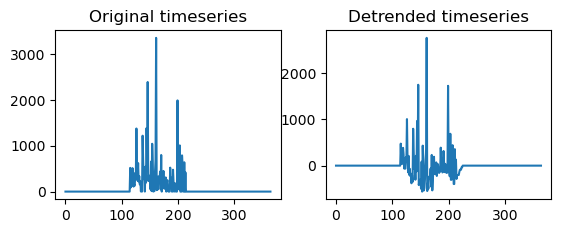

In [103]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3/4)


ax2.plot(ts_example_detrend.to_numpy())
ax2.set_title('Detrended timeseries')
ax2.set_box_aspect(3/4)

plt.show()

Perform Augmented Dickey-Fuller test of example of timeseries **after** trend removal

In [104]:
adf = adfuller(ts_example_detrend)
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -4.547375268160334
p-value: 0.00016130899692270168
Critical values:
1%: -3.4492815848836296
5%: -2.8698813715275406
10%: -2.5712138845950587


Remove trends for all timeseries found be non-stationary.

In [105]:
user_2019_detrend = user_2019.copy()

for col in non_stationary_idx_list:
    user_2019_detrend[col] = user_2019_detrend[col] - user_2019_detrend[col].rolling(window=12, min_periods=1).mean()

In [106]:
user_2019_detrend.to_csv('../dataset/time_series_trendless.csv')

### Noise detection

To find the best sliding window for the noise we used the mean of the **sums of absolute differences (SAD)** between the original timeseries and the smoothed one, then we resorted to the elbow method to choose the best window that 'doesn't smooth too much' the original timeseries.

In [107]:
noise_windows = np.array(range(1,21))

# Dict for all window sizes
mean_sad_dict = dict()

for window_size in tqdm(noise_windows):
    sum_abs_diff_users = list()

    for user_id in user_2019_detrend.columns:
        # Calculate SAD for each user
        sum_abs_diff_single_per_user = np.sum(np.abs(user_2019_detrend[user_id].rolling(window=window_size, center = True, min_periods = 1).mean() - user_2019_detrend[user_id]))
        sum_abs_diff_users.append(sum_abs_diff_single_per_user)
    
    # Average the SAD for all users to get final SAD score
    mean_sad_dict[window_size] = np.average(sum_abs_diff_users)

100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


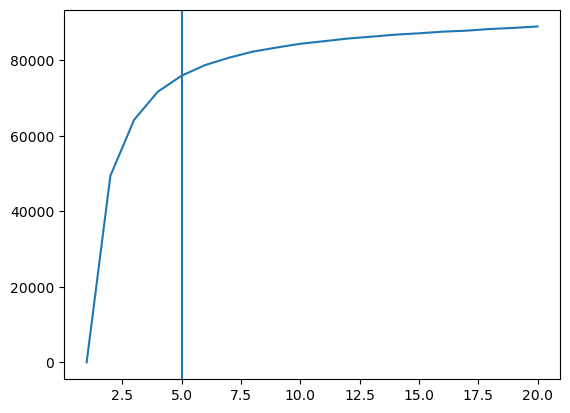

In [108]:
plt.plot(mean_sad_dict.keys(), mean_sad_dict.values())
plt.axvline(5)
plt.show()

The result of this analisys is window size = 5

In [109]:
window_size = 5

In [110]:
# Function that denoises df of timeseries given a window size
def denoiser(df, window_size):
    denoised_df = df.apply(lambda ts : ts.rolling(window=window_size, center = True, min_periods = 1).mean())

    return denoised_df

Apply the denoising function to all timeseries.

In [111]:
user_2019_denoised = denoiser(user_2019_detrend, window_size=window_size)


Plot an example timeseries before and after denoising.

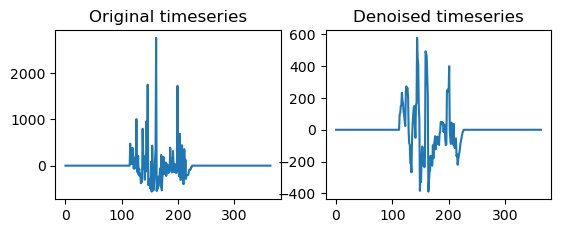

In [112]:
ts_example = user_2019_detrend[non_stationary_idx_list[4]]
ts_example_denoised = user_2019_denoised[non_stationary_idx_list[4]]

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3/4)

ax2.plot(ts_example_denoised.to_numpy())
ax2.set_title('Denoised timeseries')
ax2.set_box_aspect(3/4)


plt.show()

### Scaler with mean and std

Normalize the timeseries using Z-score normalization (mean and std)

In [113]:
# Apply normalization
user_2019_std = pd.DataFrame(columns=user_2019_denoised.columns)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  
for col in user_2019_denoised.columns:
    user_2019_std[col] = scaler.fit_transform(user_2019_denoised[col].values.reshape(1, -1)).flatten()

Show some examples of normalized timeseries.

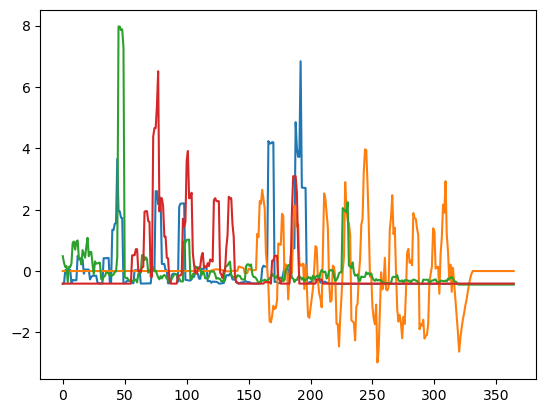

In [114]:
ts_example_1 = user_2019_std.iloc[:, 29]
ts_example_2 = user_2019_std.iloc[:, 567]
ts_example_3 = user_2019_std.iloc[:, 1000]
ts_example_4 = user_2019_std.iloc[:, 867]
plt.plot(ts_example_1.to_numpy())
plt.plot(ts_example_2.to_numpy())
plt.plot(ts_example_3.to_numpy())
plt.plot(ts_example_4.to_numpy())
plt.show()

Define the final dataset containing the preprocessed timeseries. Use transpose to have a timeseries for each row.

In [115]:
timeseries_data = np.transpose(user_2019_std.values)

## Clustering timeseries

In [22]:
def print_clusters(y, K, model):
    print("k = ", K, "| Clusters =", np.unique(y,return_counts=True)[1], "| Inertia =", model.inertia_)

In [23]:
# Function that plots sample of timeseries for each cluster

def plot_timeseries_per_cluster(labels, n_clusters):
    fig, ax = plt.subplots(math.ceil(n_clusters/2), 2)
    print(np.shape(ax))
    colors = plt.rcParams["axes.prop_cycle"]()
    fig.set_size_inches(8, 8)


    max_num_samples_per_cluster = 5
    for c in range(n_clusters):
        cluster_index = [i for i, x in enumerate(labels) if x == c] 
        random_indexes = np.random.choice(
            cluster_index, size=min(len(cluster_index), max_num_samples_per_cluster), replace=False)
        cluster_sample = timeseries_data[random_indexes]
        
        ax_idx_row = math.ceil(c/2)-1
        ax_idx_col = c % 2
        ax_c = ax[ax_idx_row][ax_idx_col]
        color = next(colors)["color"]
        ax_c.set_title('Cluster: '+str(c), y=1.0, pad=-14)
        for ts in cluster_sample:
            ax_c.plot(ts, color=color)

    plt.show()

In [24]:
# Function that plots the pieplots of bot distribution for each cluster

def plot_bot_pieplots(labels, n_clusters):
     for k in range(n_clusters):
        # Get 'bot' values for elems in cluster k
        bot_for_cluster = user_2019_bot.loc[labels == k].value_counts()
        # Show pie plot
        plt.title('Cluster: ' + str(k))
        plt.pie(bot_for_cluster, labels= bot_for_cluster.index, colors=[dict_colors_bot[v] for v in bot_for_cluster.reset_index()['bot'].to_numpy()])
        plt.show()
        print(bot_for_cluster)

### Shape-Based clustering
#### K-Means

In [71]:
from tslearn.clustering import TimeSeriesKMeans

Use euclidean metric

In [390]:
with warnings.catch_warnings(record=True):
    # Define lists of the K values for euclidean kmeans
    inertia_euclidean = list()
    models_euclidean = list()

    metric = 'euclidean'
    print("Clusters sizes for each K with", metric, "metric:")

    for n_clusters in range(2, 21):
        # Build and fit Kmeans
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=10)
        model.fit(timeseries_data)
        y = model.predict(timeseries_data)
        # Print cluster and inertia info
        print_clusters(y, n_clusters, model)

        inertia_euclidean.append(model.inertia_)
        models_euclidean.append(model)

Clusters sizes for each K with euclidean metric:
k =  2 | Clusters = [3503 3284] | Inertia = 248.30505727184908
k =  3 | Clusters = [ 457 3264 3066] | Inertia = 239.08520471513694
k =  4 | Clusters = [2938 2892  376  581] | Inertia = 231.13612504335697
k =  5 | Clusters = [1080 3192  642  196 1677] | Inertia = 229.26358808005472
k =  6 | Clusters = [1782  472  560 2659  651  663] | Inertia = 222.1130158000772
k =  7 | Clusters = [1897 2435 1031  329  460  362  273] | Inertia = 210.73434598454497
k =  8 | Clusters = [1912 1862  468 1016  326  391  363  449] | Inertia = 209.23624099932968
k =  9 | Clusters = [1826 2005 1108  454  185  234  272  321  382] | Inertia = 204.89458173047024
k =  10 | Clusters = [1197  683  275  345  184  417 1888 1221  229  348] | Inertia = 203.40242349670132
k =  11 | Clusters = [1995  365  189  264  288  265  183  339 1625  187 1087] | Inertia = 199.49909299415722
k =  12 | Clusters = [ 176  311  927  436  271  282 1786 1351  211  183  320  533] | Inertia = 

Now we plot the inertia curves of Kmeans with euclidean metrics to help the choice of the best K.

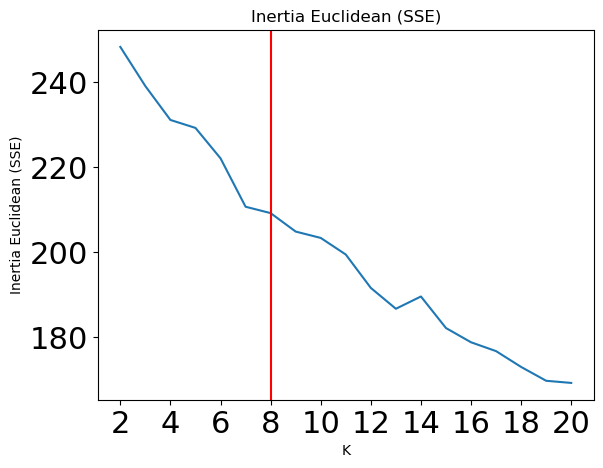

In [391]:
# Plot SSE with euclidean metric
plt.plot(range(2, len(inertia_euclidean) + 2), inertia_euclidean)
plt.ylabel('Inertia Euclidean (SSE)')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(np.arange(2,21,2))
plt.title('Inertia Euclidean (SSE)')
plt.axvline(8, color='r')
plt.show()

We choose K=8 as the best kmeans with euclidean metric, as, even it there is no clear elbow in the curve, it is a balanced number of clusters in terms of SSE and cluster sizes.

In [392]:
euclidean_n_clusters = 8
euclidean_kmeans = models_euclidean[euclidean_n_clusters-2]

(4, 2)


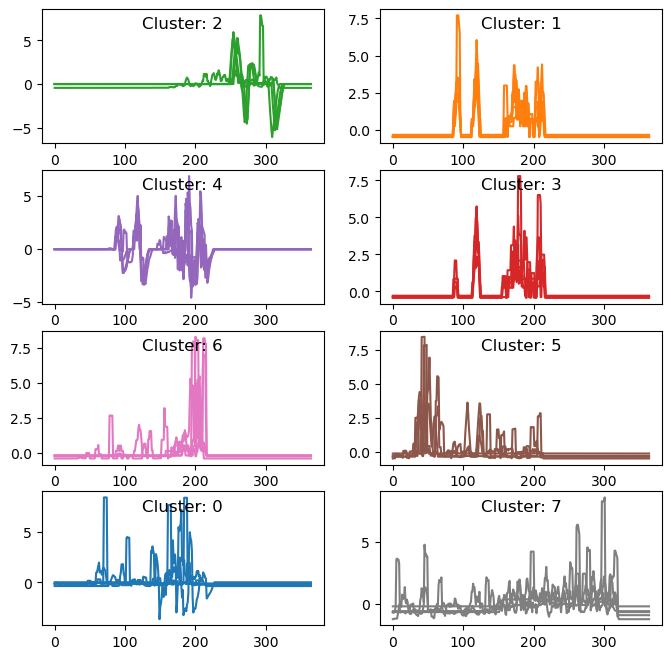

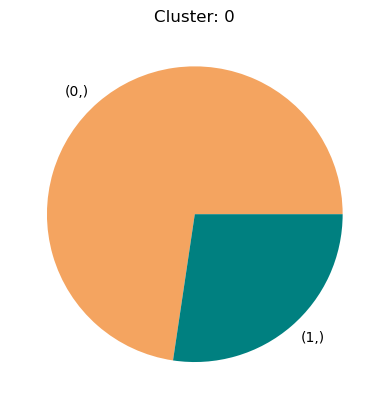

bot
0      1389
1       523
dtype: int64


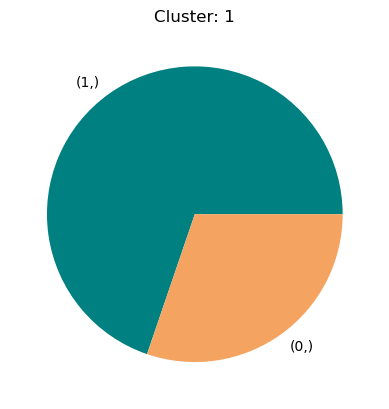

bot
1      1299
0       563
dtype: int64


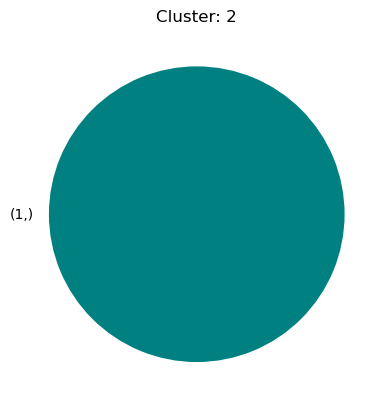

bot
1      468
dtype: int64


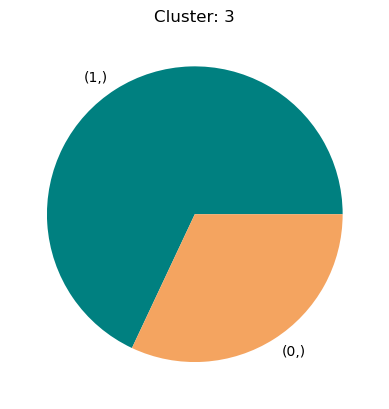

bot
1      691
0      325
dtype: int64


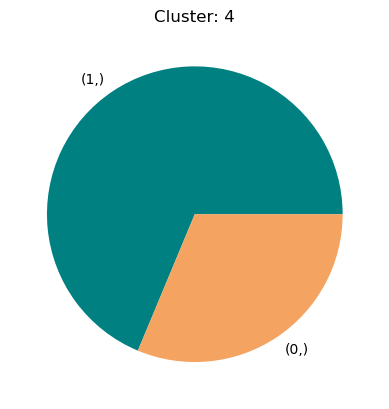

bot
1      224
0      102
dtype: int64


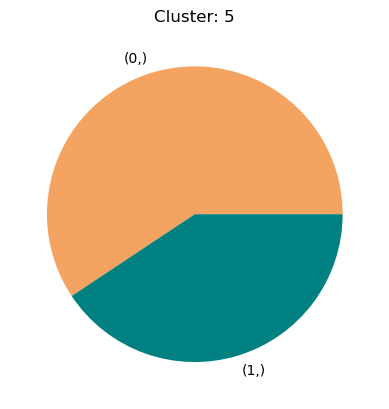

bot
0      232
1      159
dtype: int64


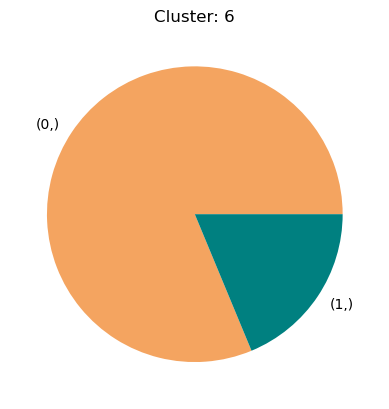

bot
0      295
1       68
dtype: int64


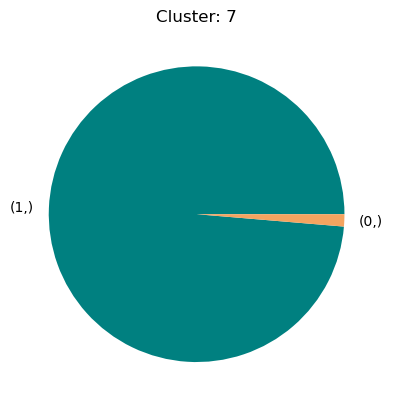

bot
1      443
0        6
dtype: int64


In [444]:
plot_timeseries_per_cluster(euclidean_kmeans.labels_, euclidean_n_clusters)
plot_bot_pieplots(euclidean_kmeans.labels_, euclidean_n_clusters)

We can see that the major differences in the clusters are in the positions of peaks and pits in the timeseries.

As for the clustering composition we can see that is well executed from the fact that not all cluster have a 50/50 split between bot and non bot, the only notable exception is cluster 5 that is composed only of 391 user which has still a majority of non bot users. We can also see that the cluster 2 has generated a cluster composed only by bots, and in the time series depiction of the cluster 2, the pattern is very specific,  the same cannot be said of cluster 7, that, although has generated an almost perfect cluster of bot, there are not any recognizable patterns in its depiction. As for the cluster 1 and 3, they are almost identical, in their depiction, but probably the euclidean metrics has not picked up their similarities, but it must be noted that their ratio of bot/non-bot is identical (around 68% of bots).

Use same number of clusters of best K-means with euclidean metric to run K-means with **DTW** metric (too computationally expensive to try all K values).

In [445]:
metric = 'dtw'
dtw_n_clusters = 8

In [446]:
model = TimeSeriesKMeans(n_clusters=dtw_n_clusters, metric=metric, max_iter=10)
model.fit(timeseries_data)
y = model.predict(timeseries_data)
# Print cluster and inertia info
print("Clustering info for KMeans with", metric, "metric")
print_clusters(y, 8, model)

inertia_dtw = model.inertia_
model_dtw = model

c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


Clustering info for KMeans with dtw metric
k =  8 | Clusters = [ 385  437 2268  303  835 1205  732  622] | Inertia = 32.09610795753886


Now we show the timeseries for each cluster

(4, 2)


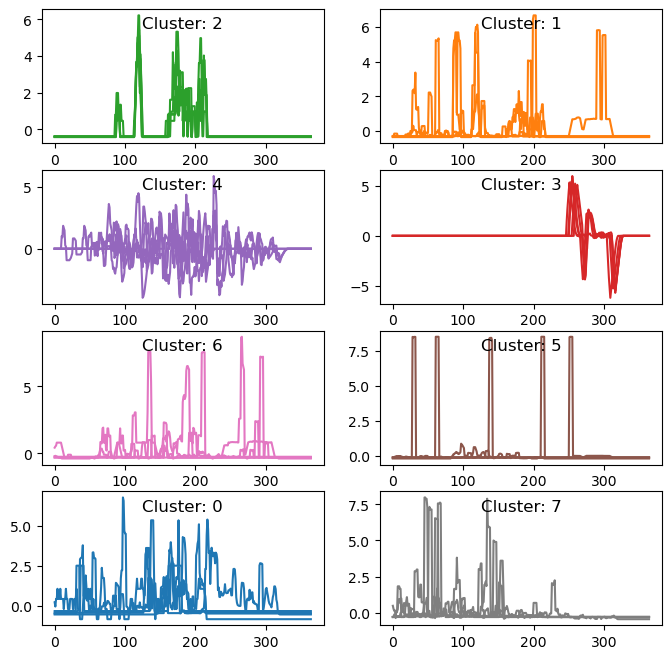

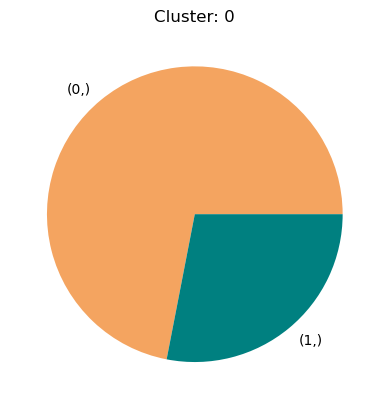

bot
0      277
1      108
dtype: int64


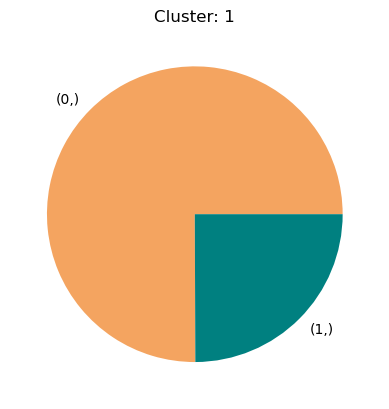

bot
0      328
1      109
dtype: int64


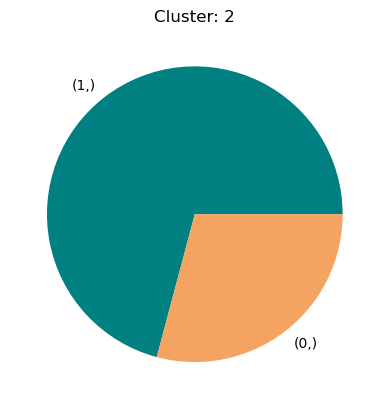

bot
1      1607
0       661
dtype: int64


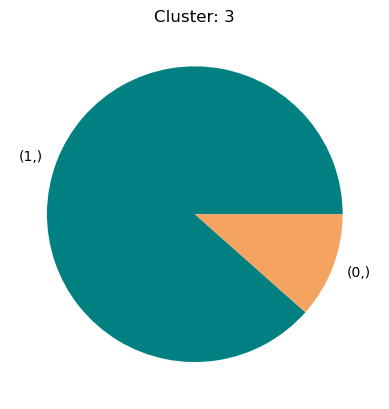

bot
1      268
0       35
dtype: int64


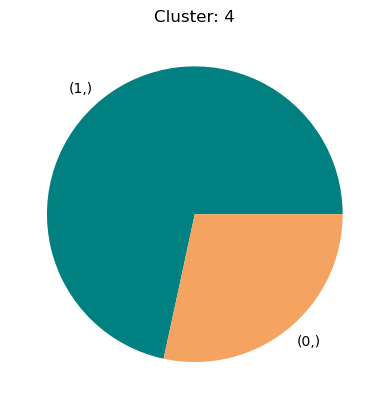

bot
1      598
0      237
dtype: int64


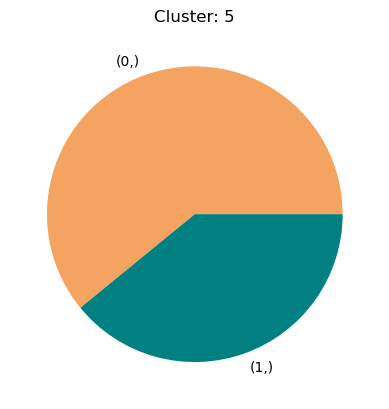

bot
0      734
1      471
dtype: int64


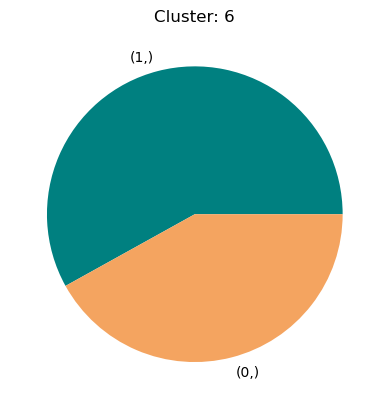

bot
1      425
0      307
dtype: int64


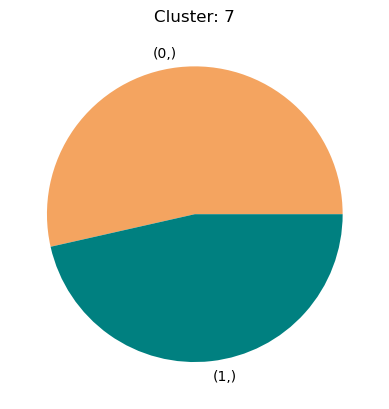

bot
0      333
1      289
dtype: int64


In [447]:
plot_timeseries_per_cluster(model_dtw.labels_, dtw_n_clusters)
plot_bot_pieplots(model_dtw.labels_, dtw_n_clusters)

DTW KMeans is similar to euclidean kmeans (some clusters seems to be equal such as DTW cluster 6 and euclidean cluster 3), but there are less clusters which have spikes in same positions.

As for the clustering composition we can see that, in constrast to what did we see during the K-Means using the euclidean metrics, that the previously separated clusters 1 and 3, they are now under the same cluster depiction (the cluster 2), that could be observed by comparing the depiction of the clusters, and their sizes, because in the case of the euclidean model the cluster 1 and 3 together were about 2800 entries, given that the dtw was performed with a K obtained by the euclidean metrics, probably a part of the 2400 entries of the cluster 2 in the dtw (the one similar to the cluster 1 and 3 of the euclidean), were dispersed in other clusters.

Also in this case we can note a cluster almost of only bots (cluster 3) that is strikinlgy similar to the depiction of the cluster 2 of the model using euclidean metrics, but in this case the cluster is not comprised of only bots anymore. The other clusters were performing good in the term of ratio between bot and non-bots but were worse that the reuslts achieved by the K-Means using the euclidean metrics.

### Feature based clustering

In [25]:
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [26]:
def calculate_features(values):
    # Define a set of features to extract from the timeseries
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

Extract features from timeseries

In [27]:
timeseries_features = [list(calculate_features(x).values())[:-2] for x in timeseries_data]

#### K-Means

Use minmax normalization for KMeans.

In [28]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(timeseries_features)

In [29]:
def KMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=300):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = KMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value)
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [30]:
# Params for kmeans
clusters_list = [x for x in range(2, 20)]
init_value = 10
iter_value = 300

# Get list of kmeans with from the list of possible k
kmeans_list = KMeansFunction (X_minmax, clusters_list, init_value, iter_value)

# Calculate SSE for each kmeans
sse_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)

100%|██████████| 18/18 [00:12<00:00,  1.44it/s]

k =  2 | Clusters = [3478 3309] | Inertia = 802.2929151643842
k =  3 | Clusters = [3139  471 3177] | Inertia = 557.3921870619588
k =  4 | Clusters = [2539 3117  431  700] | Inertia = 423.79508391920467
k =  5 | Clusters = [1840 1951  695 1940  361] | Inertia = 346.16531421687495
k =  6 | Clusters = [1843 1862  284  495  694 1609] | Inertia = 302.22613959548386
k =  7 | Clusters = [1270  283 1266  691 1640 1199  438] | Inertia = 273.2422276238822
k =  8 | Clusters = [1650  804  283  653  460  682  965 1290] | Inertia = 253.5156007418612
k =  9 | Clusters = [1189  745  682  988  283  944  454  650  852] | Inertia = 235.52038389485634
k =  10 | Clusters = [ 165  963  741  476  652  158 1245  371 1123  893] | Inertia = 219.2631094515125
k =  11 | Clusters = [ 709 1199  183  652  371  908  474  929  148 1084  130] | Inertia = 203.59541766457863
k =  12 | Clusters = [ 923  371  140  497  650  652  459  182  130  872  907 1004] | Inertia = 191.53469738502963
k =  13 | Clusters = [628 845 110 

Now we plot the SSE curve to help the choice of the best K.

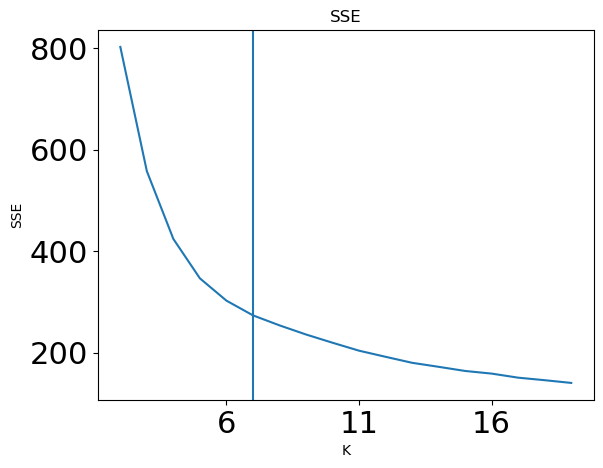

In [31]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(7)
plt.show()

In this case we choose K = 7 as we can deduct from the knee method.

In [32]:
best_n_clusters = 7
best_kmeans = kmeans_list[best_n_clusters-2]

Now we show the timeseries for each cluster

(4, 2)


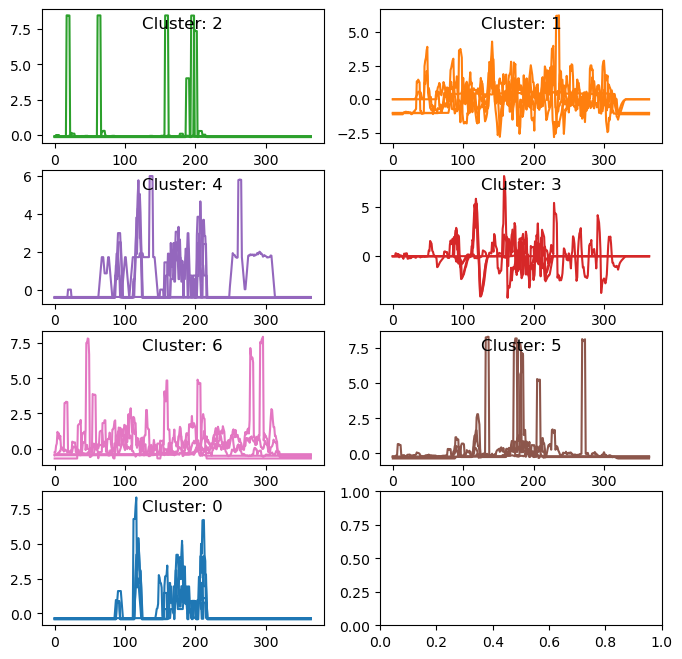

In [34]:
plot_timeseries_per_cluster(best_kmeans.labels_, best_n_clusters)

Feature based KMeans clustering seems to work well on the timeseries, clustering with good precision the ones with spikes in the same positions. It seems that it also separates in specific clusters the timeseries having negative spikes, such as cluster 3 and 1.

#### Hierachical

In [35]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fclusterdata

Use both Z-score and minmax normalization.

In [36]:
scaler = StandardScaler()
X_std = scaler.fit_transform(timeseries_features)

In [37]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(timeseries_features)

##### With minmax normalization


In [49]:
config_hierarchical_minamx = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 0.35, n_clusters: 3

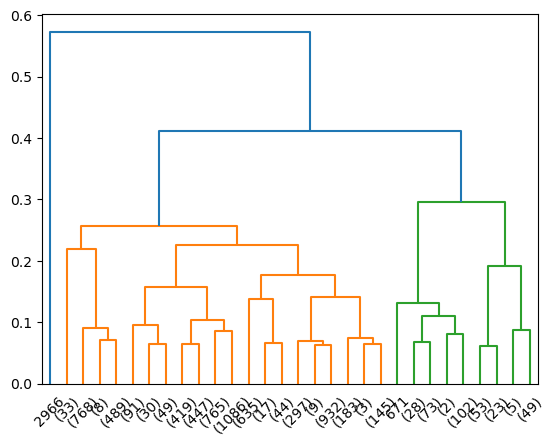

In [50]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=0.35, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.35, 'cosine', 'complete'))

method: ward, threshold: 2.0, n_clusters: 3

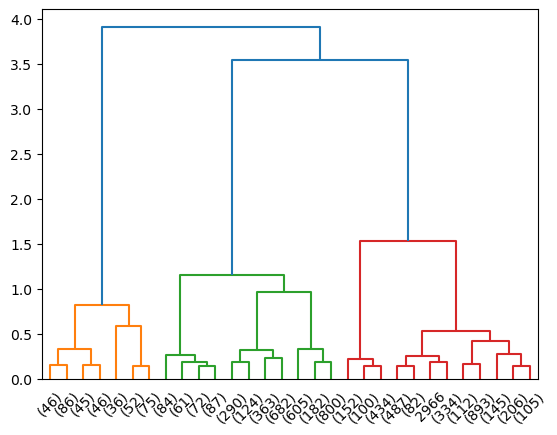

In [51]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=2.0, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((2.0, 'cosine', 'ward'))

method: average, threshold: 0.1, n_clusters: 3

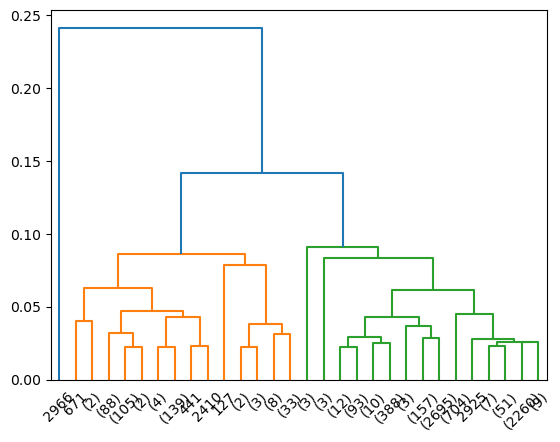

In [52]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.1, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.1, 'cosine', 'average'))

method: centroid, threshold: 0.1, n_clusters: 3

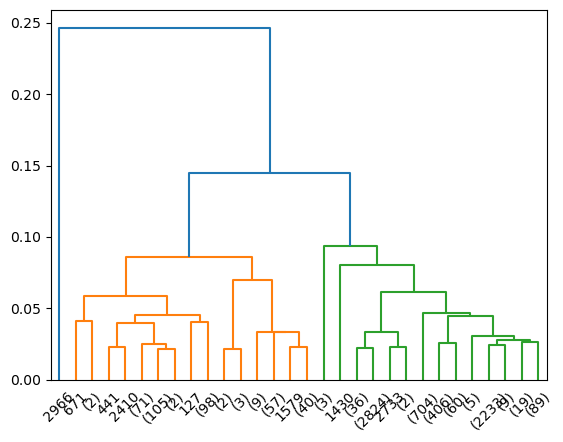

In [53]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.1, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.1, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [54]:
cluster_list_minmax = []
for treshold, metric_minmax, method_minmax in config_hierarchical_minamx:
    cluster = fclusterdata(X=X_minmax,
     t=treshold , criterion='distance', metric=metric_minmax, method=method_minmax)
     
    cluster_list_minmax.append(cluster)

Calculate Silhouette for each clustering.

In [56]:
for i, clustering in enumerate(cluster_list_minmax):
    treshold, metric, method = config_hierarchical_minamx[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_minmax, clustering)
    except:
        silhouette = np.nan
    print("MINMAX - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

MINMAX - dist: cosine , method: complete , SILHOUTTE: 0.47671200373359185 , n_clusters: 3
Clusters Size: [6450, 336, 1]


MINMAX - dist: cosine , method: ward , SILHOUTTE: 0.3987722241701328 , n_clusters: 3
Clusters Size: [386, 3350, 3051]


MINMAX - dist: cosine , method: average , SILHOUTTE: 0.4596390621521396 , n_clusters: 3
Clusters Size: [390, 6396, 1]


MINMAX - dist: cosine , method: centroid , SILHOUTTE: 0.45846510218701225 , n_clusters: 3
Clusters Size: [394, 6392, 1]




##### With mean-std normalization


In [57]:
config_hierarchical_std = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 1.65, n_clusters: 9

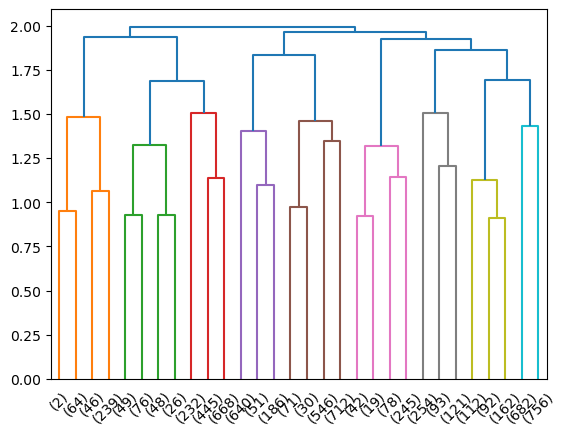

In [58]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=1.65, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((1.65, 'cosine', 'complete'))

method: ward, threshold: 14, n_clusters: 7

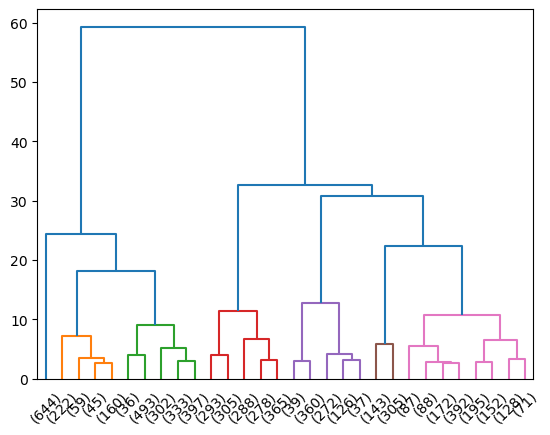

In [59]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=14, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((14, 'cosine', 'ward'))

method: average, threshold: 0.8, n_clusters: 5

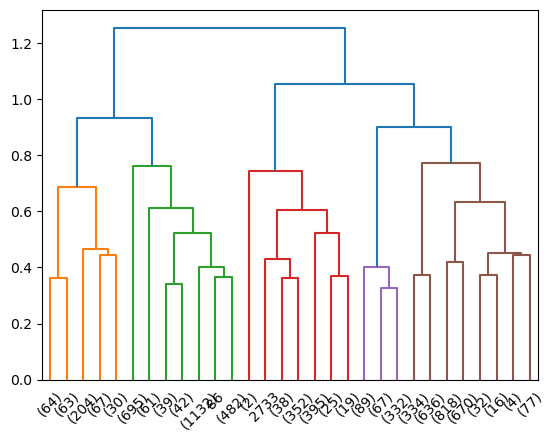

In [60]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.8, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.8, 'cosine', 'average'))

method: centroid, threshold: 0.7, n_clusters: 7

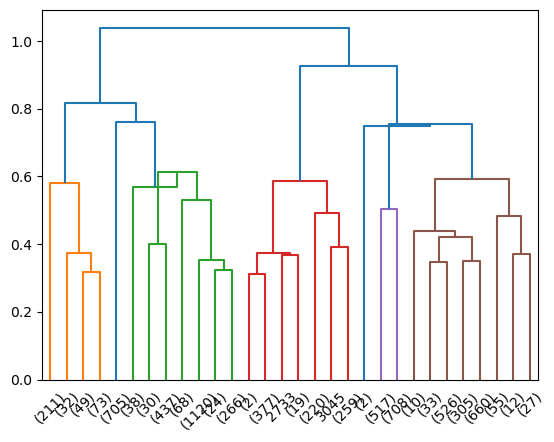

In [61]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.7, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.7, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [62]:
cluster_list_std = []
for treshold, metric_std, method_std in config_hierarchical_std:
    cluster = fclusterdata(X=X_std,
     t=treshold , criterion='distance', metric=metric_std, method=method_std)
     
    cluster_list_std.append(cluster)

Calculate Silhouette for each clustering.

In [63]:
for i, clustering in enumerate(cluster_list_std):
    treshold, metric, method = config_hierarchical_std[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_std, clustering)
    except:
        silhouette = np.nan
    print("STD - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

STD - dist: cosine , method: complete , SILHOUTTE: 0.1380786176966339 , n_clusters: 9
Clusters Size: [351, 199, 1345, 877, 1359, 384, 468, 366, 1438]


STD - dist: cosine , method: ward , SILHOUTTE: 0.2564560351816744 , n_clusters: 7
Clusters Size: [644, 486, 1561, 1529, 834, 448, 1285]


STD - dist: cosine , method: average , SILHOUTTE: 0.19454868097616196 , n_clusters: 5
Clusters Size: [428, 2452, 832, 488, 2587]


STD - dist: cosine , method: centroid , SILHOUTTE: 0.2574524005171416 , n_clusters: 7
Clusters Size: [365, 705, 1983, 879, 2, 1225, 1628]




The final chosen hierarchical cluster selected is the one with **ward** method and **std** normalization, as it has an appropriate number of clusters and elements for each clusters, a dendrogram with well distanciated branches and relatively higher Silhouette for its number of clusters.

In [64]:
best_hierarchical = np.array(cluster_list_std[1]) - 1
best_n_clusters = len(np.unique(best_hierarchical))

We plot the timeseries for the hierarchical clustering with with **ward** method and **std** normalization.

(4, 2)


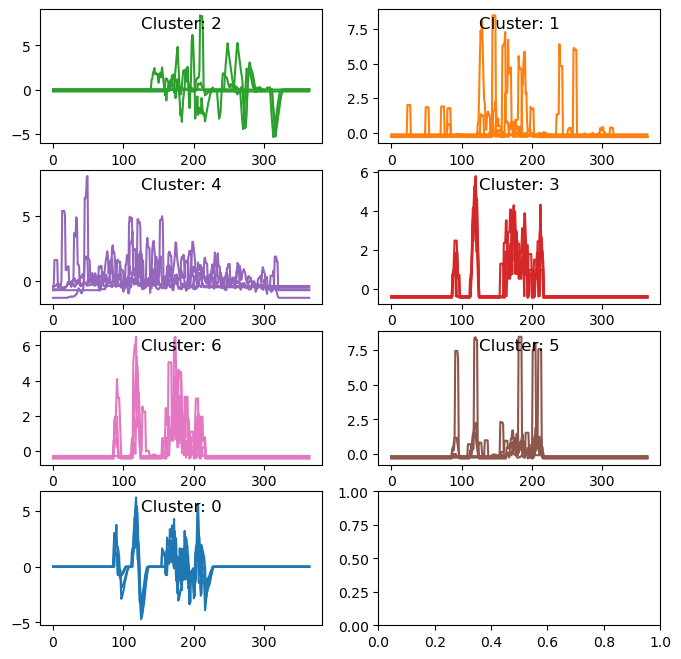

In [65]:
plot_timeseries_per_cluster(best_hierarchical, best_n_clusters)

Hierarchical seems to have clusters which have less coincidence in the positions of spikes, compared to KMeans. In particular cluster 0 seems to have many timeseries with negative spikes.

### Compression based clustering

In [66]:
from tslearn.piecewise import PiecewiseAggregateApproximation

We use PAA as the compression.

In [67]:
n_paa_segments = 27

paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(timeseries_data)

c:\Users\giaco\anaconda3\envs\PythonGPU\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


Show PAA transformed timeseries

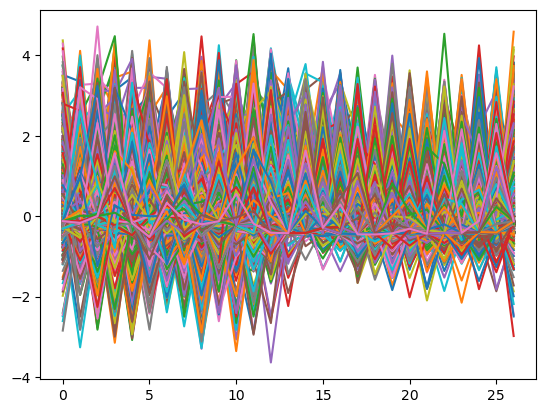

In [68]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [72]:
def TSKMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=5):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = TimeSeriesKMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value, random_state=0, metric='euclidean')
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [73]:
# Params for kmeans
clusters_list = [x for x in range(2, 21)]
init_value = 5
iter_value = 10

# Get list of kmeans with from the list of possible k
kmeans_list = TSKMeansFunction (X_minmax, clusters_list, init_value, iter_value)

# Calculate SSE for each kmeans
sse_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)

100%|██████████| 19/19 [08:47<00:00, 27.76s/it]

k =  2 | Clusters = [3309 3478] | Inertia = 0.11821032271534396
k =  3 | Clusters = [3177 3139  471] | Inertia = 0.08212644571415294
k =  4 | Clusters = [3113 2542  432  700] | Inertia = 0.062442407357880626
k =  5 | Clusters = [1964 1936 1832  695  360] | Inertia = 0.051005024972885706
k =  6 | Clusters = [1842 1855  497  286  694 1613] | Inertia = 0.04453394506659928
k =  7 | Clusters = [1268 1271  691  436  283 1640 1198] | Inertia = 0.04025998959277162
k =  8 | Clusters = [1036 1668  677  283  470  754 1342  557] | Inertia = 0.037307379717682235
k =  9 | Clusters = [ 477  898  671  283  376  744  960 1254 1124] | Inertia = 0.03447610600780919
k =  10 | Clusters = [ 479  892  671  279  376  707  955 1197 1075  156] | Inertia = 0.03209606758493821
k =  11 | Clusters = [ 430  835  671  277  376  587  894 1048  808  134  727] | Inertia = 0.03024781324614896
k =  12 | Clusters = [900 986 458 650 137 476 914 875 709 170 371 141] | Inertia = 0.028540094932027953
k =  13 | Clusters = [752 

Now we plot the SSE curve to help the choice of the best K.

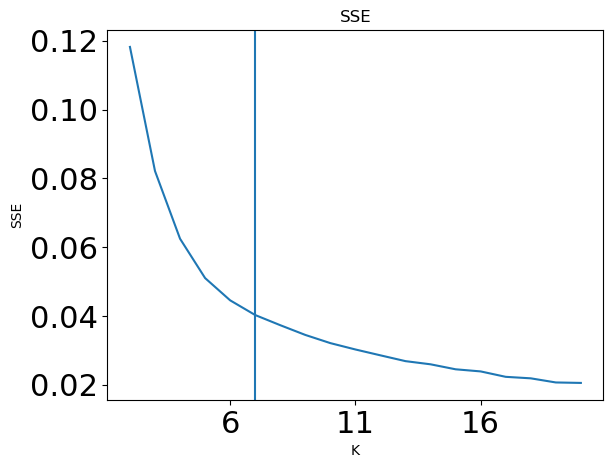

In [74]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(7)
plt.show()

The best K according to the SSE knee method is K=7

In [75]:
best_n_clusters = 7
best_kmeans = kmeans_list[best_n_clusters-2]

Now we show the timeseries for each cluster

(4, 2)


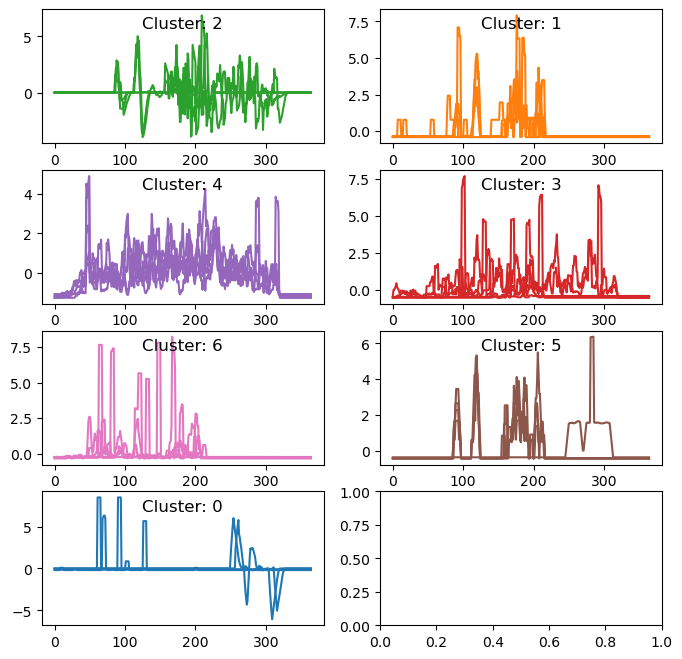

In [76]:
plot_timeseries_per_cluster(best_kmeans.labels_, best_n_clusters)

Clustering is similar to the one obtained with shape clustering, but some clusters (such as 4 and 3) seems to have less recognizable common patterns for the timeseries.

Show cluster centers for each cluster of the compressed timeseries next to the cluster means of the original timeseries.

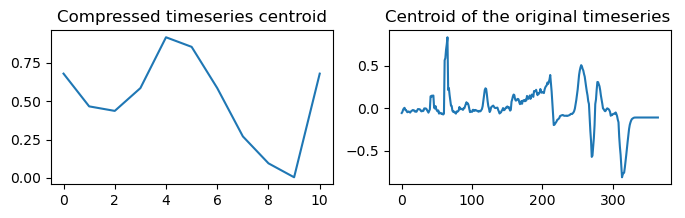

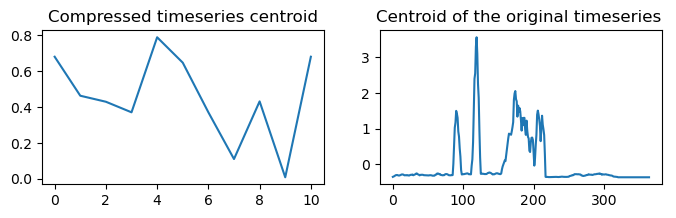

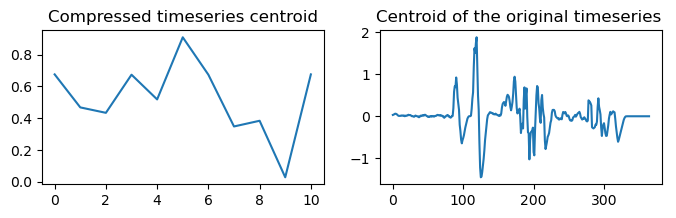

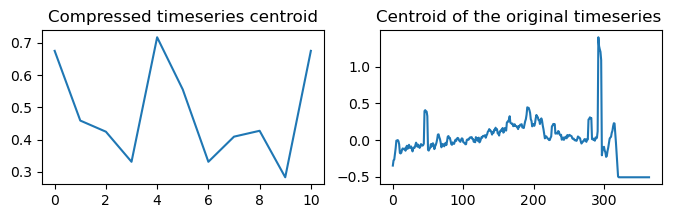

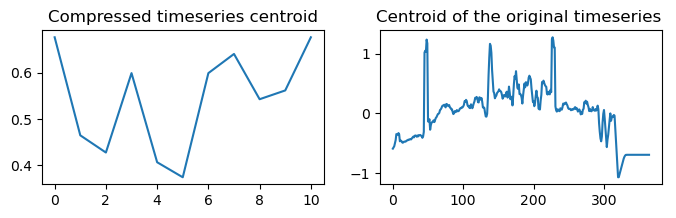

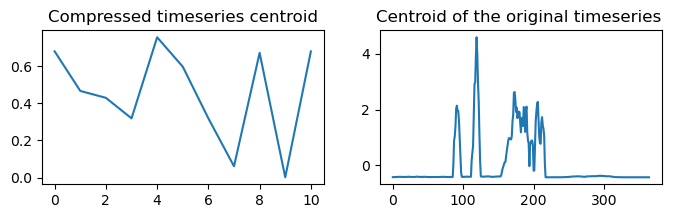

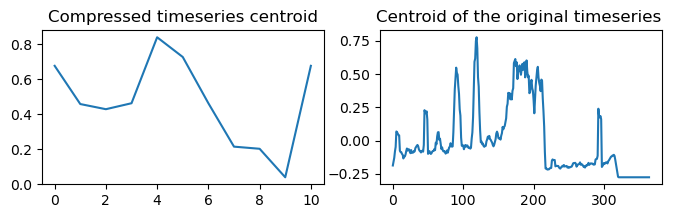

In [78]:
for c in range(best_n_clusters):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(best_kmeans.cluster_centers_[c])#.reshape(X_paa.shape[1], best_n_clusters))
    ax1.set_title("Compressed timeseries centroid")

    ax2.plot(np.mean(timeseries_data[np.where(best_kmeans.labels_ == c)], axis=0))
    ax2.set_title("Centroid of the original timeseries ")
    
    fig.set_size_inches(8, 2)
    plt.show()

It seems there is not much correspondance between PAA timeseries centroid and average cluster of the original timeseries.

### Clustering Conclusions

Of the methods used for clustering, the one which, subjected to further analysis, produced the best results was the Shape-Based K-Means with Euclidean metric.

## Shapelets

In [116]:
from tensorflow.keras.optimizers import Adagrad
from tslearn.shapelets import LearningShapelets
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [117]:
timeseries_data = np.transpose(user_2019_std.values)

Get labels of each timeseries

In [127]:
labels = user_2019_bot.values


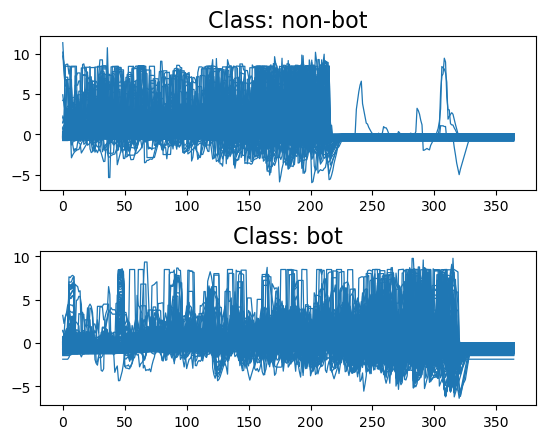

In [130]:
plt.figure()
for i, classe in enumerate(['non-bot', 'bot']):
    plt.subplot(2, 1, i + 1)
    mask = labels.T == i
    for x in timeseries_data[mask[0]]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)
    

plt.subplots_adjust(hspace=0.4)

plt.show()

Train test split 0.25

In [131]:
X_train, X_test, y_train, y_test = train_test_split(timeseries_data, labels,
 test_size=0.25, random_state=1000, stratify = labels)


In [132]:
print(X_train.shape)
print(X_test.shape)

(915, 365)
(306, 365)


Use grabocka method to identify the number of shapelets for each shapelet size

In [161]:
n_ts, ts_sz = X_train.shape
n_classes = 2

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.06,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 915
ts_sz 365
n_classes 2
shapelet_sizes {21: 5}


Build the shapelet model to extract shapelet. We use shapelet sizes and numbers from previous grabocka method.

In [162]:
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.005,
                            max_iter=10,
                            random_state=42,
                            verbose=1)

c:\Users\giaco\anaconda3\envs\PythonGPU\lib\site-packages\tslearn\shapelets\shapelets.py:357: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  FutureWarning)


Fit the shapelet model

In [163]:
shp_clf.fit(X_train, y_train)

c:\Users\giaco\anaconda3\envs\PythonGPU\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Train on 915 samples
Epoch 1/10
915/915 [==============================] - 3s 3ms/sample - loss: 0.7483 - binary_accuracy: 0.5093 - binary_crossentropy: 0.7421
Epoch 2/10
915/915 [==============================] - 1s 564us/sample - loss: 0.6653 - binary_accuracy: 0.6284 - binary_crossentropy: 0.6578
Epoch 3/10
915/915 [==============================] - 0s 506us/sample - loss: 0.6339 - binary_accuracy: 0.6568 - binary_crossentropy: 0.6252
Epoch 4/10
915/915 [==============================] - 0s 467us/sample - loss: 0.6122 - binary_accuracy: 0.6776 - binary_crossentropy: 0.6029
Epoch 5/10
915/915 [==============================] - 1s 704us/sample - loss: 0.5975 - binary_accuracy: 0.6962 - binary_crossentropy: 0.5880
Epoch 6/10
915/915 [==============================] - 1s 687us/sample - loss: 0.5863 - binary_accuracy: 0.7038 - binary_crossentropy: 0.5762
Epoch 7/10
915/915 [==============================] - 0s 470us/sample - loss: 0.5825 - binary_accuracy: 0.6995 - binary_crossentropy: 0

LearningShapelets(batch_size=16, max_iter=10, n_shapelets_per_size={21: 5},
                  optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000002B988AE1508>,
                  random_state=42, verbose=1, weight_regularizer=0.005)

Predict on test

In [164]:
y_pred_test = shp_clf.predict(X_test)
predicted_locations = shp_clf.locate(X_test)

306/306 [==============================] - 0s 646us/sample


In [165]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.71      0.68      0.69       142
        True       0.73      0.76      0.74       164

    accuracy                           0.72       306
   macro avg       0.72      0.72      0.72       306
weighted avg       0.72      0.72      0.72       306



Print all the shapelets

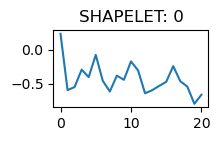

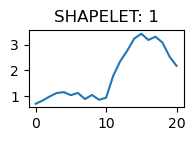

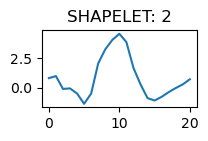

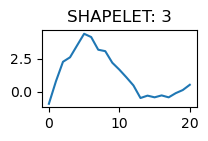

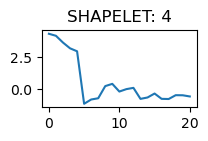

In [166]:
len(shp_clf.shapelets_as_time_series_)
for i, shp in enumerate(shp_clf.shapelets_as_time_series_):
    plt.figure(figsize=(2,1))
    plt.title(f"SHAPELET: {i}")
    plt.plot(shp)
    plt.show()

In [167]:
#7 11 17 2000

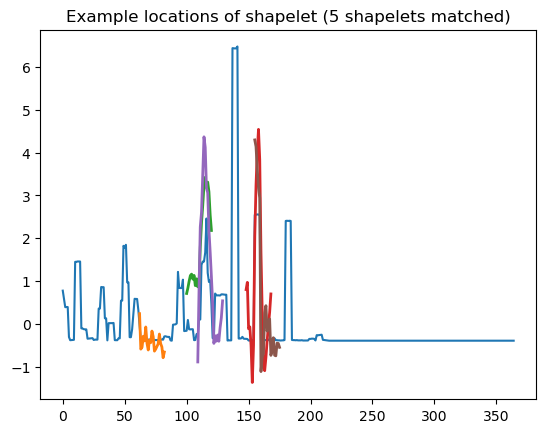

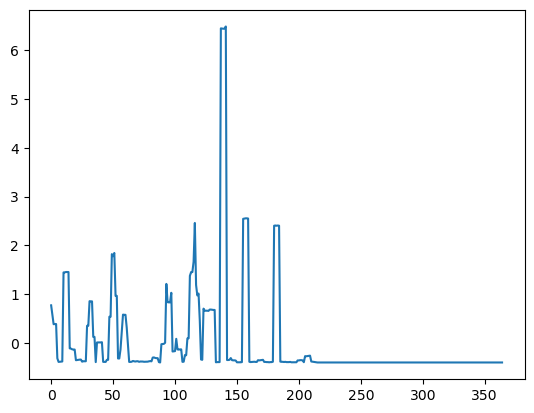

In [168]:
ts_id = 12

n_shapelets = sum(shapelet_sizes.values())


plt.plot(X_test[ts_id].ravel())
count = 0
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    if t0 > 0:
        plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
        count+=1
plt.title("Example locations of shapelet ({} shapelets matched)".format(count))
plt.show()
plt.plot(X_test[ts_id].ravel())
plt.show()
